# COMP 484 - Practical Assignment 2

#### Ramraj Chimouriya
#### CE IV/I

## Chapter 2 - Classifying with real world examples

___

### The Iris Dataset

Iris dataset is a classic dataset from the 1930s. The dataset contains 4 features namely,

- sepal width 
- sepal length 
- petal length 
- petal width.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Load iris_dataset from sklearn

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

features = data.data
feature_names = data.feature_names

target = data.target
target_names = data.target_names

labels = target_names[target]

Plotting all 2D projections of the features.

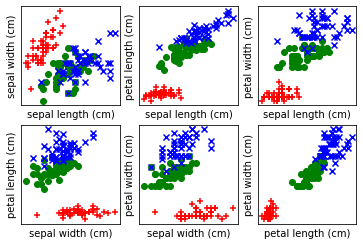

In [3]:
fig, axes = plt.subplots(2,3)
pairs = [(0,1), (0,2), (0, 3), (1, 2), (1, 3), (2, 3)]

color_markers = [
        ('r', '+'),
        ('g', 'o'),
        ('b', 'x'),
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[
                    target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])


### Building first classification model

In [4]:
from sklearn import tree

tr = tree.DecisionTreeClassifier(min_samples_leaf=10)
tr.fit(features, labels)

DecisionTreeClassifier(min_samples_leaf=10)

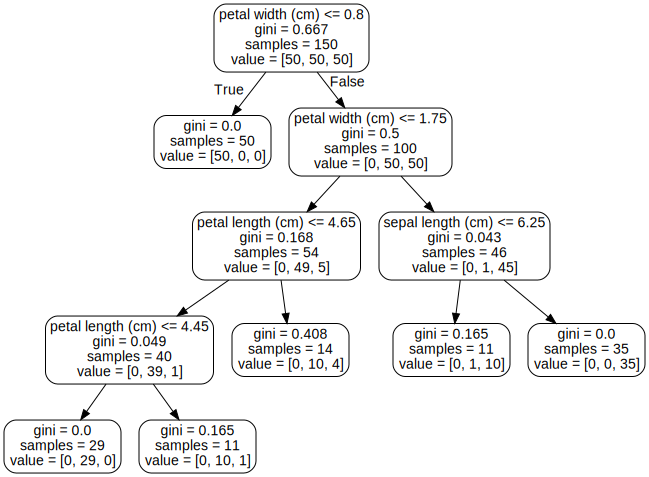

In [5]:
import graphviz
tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file="decision.dot")

graphviz.Source(open("decision.dot").read())

In [6]:
prediction = tr.predict(features)
print(f"Accuracy - {np.mean(prediction==labels) * 100} %")

Accuracy - 96.0 %


Since, we train and evaluate for same data set, the code was optimized for that data set. So, the accuracy is obviously great.

Now, let us split the data aset into two sets, one for training and another data set for testing.

### Evaluation - holding out data and cross validation

Performing leave-one-out cross-validation, where every features in the data set acts as train data except one in which testing is performed. The process is repeated by leaving next data in another iteration and so on. So that, every data set acts as train data as well as test data. 

In [7]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

In [8]:
print(f"Accuracy with leave-one-out cross-validation - {np.mean(predictions.ravel() == labels) * 100} %")

Accuracy with leave-one-out cross-validation - 95.33333333333334 %


Skitlearn provides model for performing cross validation, which can be performed as follows.

In [9]:
from sklearn import model_selection

predictions = model_selection.cross_val_predict(
    tr,
    features,
    labels,
    cv=model_selection.LeaveOneOut()
)

print(np.mean(predictions==labels))

0.9533333333333334


___

### Seeds Dataset

Seeds dataset consists of measurements of wheat seeds. There are seven features that are present, which are as follows:

- Area A
- Perimeter P
- Compactness C = (4 x pi x A) / P^2
- Length of kernel
- Width of kernel
- Assymetry coefficient
- Length of kernel groove

In [10]:
def load_dataset(dataset_name):
    features = []
    target = []
    target_names = set()
    with open('./data/{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            features.append([float(tk) for tk in tokens[:-1]])
            target.append(tokens[-1])
            target_names.add(tokens[-1])
    features = np.array(features)

    target_names = list(target_names)
    target_names.sort()
    target = np.array([target_names.index(t) for t in target])
    return {
            'features': features,
            'target_names': target_names,
            'target': target,
            }

In [11]:
feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
data = load_dataset('seeds')
features = data['features']
target = data['target']

### Nearest neighbour classification

In this method, when classifying a new element, this looks at the training data for the object that is closest to it, its nearest neighbour. Then, it returns its label as the answer.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

We will also use cross-validation to look at our data.

In [21]:
kf = model_selection.KFold(n_splits=5, shuffle=False)
means = []
for training, testing in kf.split(features):
    knn.fit(features[training], target[training])
    prediction = knn.predict(features[testing])

    curmean = np.mean(prediction == target[testing])
    means.append(curmean)

print(f"Accuracy with 5-fold cross-validation - {np.mean(means) * 100} %")

Accuracy with 5-fold cross-validation - 83.8095238095238 %


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=5)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

means = []
for training,testing in kf.split(features):
    classifier.fit(features[training], target[training])
    prediction = classifier.predict(features[testing])

    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print(f'Mean accuracy: {np.mean(means) * 100} %')

Mean accuracy: 86.66666666666666 %


### Looking at the decision boundries

In [23]:
def plot_decision_space(clf, features, target, use_color=True):
    from matplotlib.colors import ListedColormap

    clf.fit(features[:, [0,2]], target)

    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)
    C = clf.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if use_color:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])

    fig,ax = plt.subplots()
    ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
    for lab, ma in zip(range(3), "Do^"):
        ax.plot(features[target == lab, 0], features[
                 target == lab, 2], ma, c=(1., 1., 1.), ms=6)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    return fig

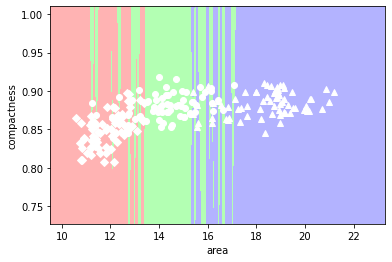

In [26]:
_ = plot_decision_space(knn, features, target)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()),
                       ('knn', classifier)])

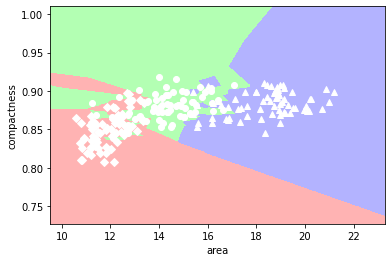

In [25]:
_ = plot_decision_space(classifier, features, target)

### Which classifier to use

A classifier named **random forests** is the best classifer for majority of problems.

In [30]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
predict = model_selection.cross_val_predict(rf, features, target)
print(f"Accuracy of RF : {np.mean(predict==target) * 100} %")

Accuracy of RF : 88.57142857142857 %
